In [2187]:
## Importo librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2189]:
# importo librerias de scikit learn los modelos de entrenamiento.
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn import set_config

In [2190]:
# Configuro opciones para poder visualizar todas las columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2191]:
telco = pd.read_csv('./telco_churn_clusterai.csv', delimiter=',',encoding='latin-1')
telco.head(3)

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,Female,NaN,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,NaN,Electronic check,29.85,29.85,No
1,1,5575-GNVDE,Male,0.0,No,No,34.0,Yes,No,NaN,Yes,No,Yes,No,No,No,One year,No,Mailed check,NaN,1889.5,No
2,2,3668-QPYBK,Male,0.0,No,No,2.0,NaN,No,NaN,Yes,NaN,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [2192]:
print(f'Shape: {np.shape(telco)}')

Shape: (7043, 22)


# **1) Preprocesamiento**

### **Encuadre del Data set**

In [2199]:
#Reemplazo el valor "No phone service" por "No" para facilitar la comprension de dataset

In [2200]:
# Listo las columnas que tiene 2No phone service"
columns_to_replace = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
# Reemplazo "No internet service" por "No" en las columnas especificadas
telco[columns_to_replace] = telco[columns_to_replace].replace('No internet service', 'No')


In [2201]:
# Verifico el resultado
for column in columns_to_replace:
    print(f"{column} unique values: {telco[column].unique()}")

OnlineSecurity unique values: ['No' 'Yes' nan]
OnlineBackup unique values: ['Yes' 'No' nan]
DeviceProtection unique values: ['No' 'Yes']
TechSupport unique values: ['No' 'Yes']
StreamingTV unique values: ['No' 'Yes']
StreamingMovies unique values: ['No' 'Yes']


#### Imputacion de missings para variables categoricas

In [2203]:
categorical_columns = telco.select_dtypes(include=['object']).columns
telco[categorical_columns] = telco[categorical_columns].fillna('sin valor')
print("Después de fillna para categóricas:")
print(telco[categorical_columns].isnull().sum())

Después de fillna para categóricas:
customerID          0
gender              0
Partner             0
Dependents          0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
TotalCharges        0
Churn               0
dtype: int64


# **2) Exploratory Data Analisis**

#### Convierto y completo TotalCharges y MonthlyCharges

In [2212]:
# Convierto 'TotalCharges' y 'MonthlyCharges' a numérico, manejando valores faltantes
for col in ['TotalCharges', 'MonthlyCharges']:
    telco[col] = pd.to_numeric(telco[col], errors='coerce')
    telco[col].fillna(0, inplace=True)

C:\Users\joaqpach\AppData\Local\Temp\ipykernel_13704\1526225934.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  telco[col].fillna(0, inplace=True)


#### Verificacion

In [2215]:
# Verifico que no haya NaN 
print("Valores faltantes en 'MonthlyCharges':", telco['MonthlyCharges'].isnull().sum())
print("Valores faltantes en 'TotalCharges':", telco['TotalCharges'].isnull().sum())

Valores faltantes en 'MonthlyCharges': 0
Valores faltantes en 'TotalCharges': 0


### Eliminacion de missings para variables numericas

In [2218]:
total = telco.isnull().sum().sort_values(ascending=False)
percent = (telco.isnull().sum()/telco.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(14)

,Total,Percent
SeniorCitizen,916,0.130058
tenure,916,0.130058
Unnamed: 0,0,0.000000
DeviceProtection,0,0.000000
TotalCharges,0,0.000000
MonthlyCharges,0,0.000000
PaymentMethod,0,0.000000
PaperlessBilling,0,0.000000
Contract,0,0.000000
StreamingMovies,0,0.000000


In [2220]:
# # Verifico que no haya NaN en variables numéricas
numeric_columns = telco.select_dtypes(include=[np.number]).columns
print("Antes de dropna, NaN en numéricas:")
print(telco[numeric_columns].isnull().sum())

Antes de dropna, NaN en numéricas:
Unnamed: 0          0
SeniorCitizen     916
tenure            916
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [2222]:
# Aplico dropna
telco.dropna(how='any', inplace=True)

In [2224]:
print(telco.isnull().sum())

Unnamed: 0          0
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [2226]:
print(f'Nos quedamos con un df de {telco.shape[0]} filas x{telco.shape[1]} columnas')

Nos quedamos con un df de 5320 filas x22 columnas


#### Elimino las variables "Unnamed: 0" y "customerID" ya que son variables keys del dataset y no aportan informacion

In [2230]:
ids_vars = ["Unnamed: 0", "customerID"] # creo una lista de las variables que decidimos eliminar
telco.drop(ids_vars, axis=1,inplace= True)
telco.shape

(5320, 20)

### Seleccion de variables

In [2233]:
# Voy a probar diversas opciones y me quedare con la que performa mejor

### Opcion 1

In [2236]:
# Identifico y transformo columnas binarias
binary_columns = [col for col in telco_opcion1.select_dtypes(include=['object']).columns if set(telco_opcion1[col].dropna().unique()) <= {'Yes', 'No', 'No'}]
for column in binary_columns:
    telco_opcion1[column] = telco_opcion1[column].map({'Yes': 1, 'No': 0})

In [2238]:
# Identifico y transformo columnas no binarias
non_binary_categorical_columns = list(set(telco_opcion1.select_dtypes(include=['object']).columns) - set(binary_columns))
telco_opcion1 = pd.get_dummies(telco_opcion1, columns=non_binary_categorical_columns, drop_first=True, dtype=int)

In [2242]:
# Verifico el resultado
print(telco_opcion1.head())

   SeniorCitizen  tenure  DeviceProtection  TechSupport  StreamingTV  \
1            0.0    34.0                 1            0            0   
2            0.0     2.0                 0            0            0   
5            0.0     8.0                 1            0            1   
6            0.0    22.0                 0            0            1   
7            0.0    10.0                 0            0            0   

   StreamingMovies  MonthlyCharges  TotalCharges  Churn  OnlineBackup_Yes  \
1                0            0.00       1889.50      0                 0   
2                0           53.85        108.15      1                 0   
5                1           99.65        820.50      1                 0   
6                0           89.10       1949.40      0                 1   
7                0           29.75        301.90      0                 0   

   OnlineBackup_sin valor  PhoneService_Yes  PhoneService_sin valor  \
1                       0        

In [2244]:
# Verificamo como quedo el data-set
print(f'Nos quedamos con un data-set de {telco_opcion1.shape[0]} filas x{telco_opcion1.shape[1]} columnas')

Nos quedamos con un data-set de 5320 filas x36 columnas


In [2246]:
telco_opcion1.head(3)

,SeniorCitizen,tenure,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MonthlyCharges,TotalCharges,Churn,OnlineBackup_Yes,OnlineBackup_sin valor,PhoneService_Yes,PhoneService_sin valor,OnlineSecurity_Yes,OnlineSecurity_sin valor,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,PaymentMethod_sin valor,MultipleLines_No phone service,MultipleLines_Yes,MultipleLines_sin valor,InternetService_Fiber optic,InternetService_No,InternetService_sin valor,Contract_One year,Contract_Two year,Contract_sin valor,Partner_Yes,Partner_sin valor,gender_Male,gender_sin valor,Dependents_Yes,Dependents_sin valor,PaperlessBilling_Yes,PaperlessBilling_sin valor
1,0.0,34.0,1,0,0,0,0.00,1889.50,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0
2,0.0,2.0,0,0,0,0,53.85,108.15,1,0,1,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
5,0.0,8.0,1,0,1,1,99.65,820.50,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


#### Guardar el DataFrame procesado como un archivo CSV para levantarlo en Notebook "Modelo de entrenamiento"

In [2249]:
telco_opcion1.to_csv('telco_processed1.csv', index=False)

### Opcion 2

In [2255]:
telco_opcion2 = telco.copy()

In [2257]:
# Identifico y transformo columnas binarias
binary_columns = [col for col in telco_opcion2.select_dtypes(include=['object']).columns if set(telco_opcion2[col].dropna().unique()) <= {'Yes', 'No', 'No'}]
for column in binary_columns:
    telco_opcion2[column] = telco_opcion2[column].map({'Yes': 1, 'No': 0})

In [2259]:
# Identifico y transformo columnas no binarias
non_binary_categorical_columns = list(set(telco_opcion2.select_dtypes(include=['object']).columns) - set(binary_columns))
telco_opcion2 = pd.get_dummies(telco_opcion2, columns=non_binary_categorical_columns, drop_first=True, dtype=int)

In [2261]:
# Verifico el resultado
print(telco_opcion2.head())

   SeniorCitizen  tenure  DeviceProtection  TechSupport  StreamingTV  \
1            0.0    34.0                 1            0            0   
2            0.0     2.0                 0            0            0   
5            0.0     8.0                 1            0            1   
6            0.0    22.0                 0            0            1   
7            0.0    10.0                 0            0            0   

   StreamingMovies  MonthlyCharges  TotalCharges  Churn  OnlineBackup_Yes  \
1                0            0.00       1889.50      0                 0   
2                0           53.85        108.15      1                 0   
5                1           99.65        820.50      1                 0   
6                0           89.10       1949.40      0                 1   
7                0           29.75        301.90      0                 0   

   OnlineBackup_sin valor  PhoneService_Yes  PhoneService_sin valor  \
1                       0        

#### Analizo correlacion entre las variables

In [2265]:
# Calculo matriz de correlación
correlation_matrix = telco_opcion2.corr()

In [2267]:
# Extraigo la correlación con 'Churn'
correlation_with_churn = correlation_matrix['Churn'].sort_values(ascending=False)

In [2269]:
# Muestro las correlaciones
print(correlation_with_churn)

Churn                                    1.000000
PaymentMethod_Electronic check           0.268756
InternetService_Fiber optic              0.266611
PaperlessBilling_Yes                     0.157999
SeniorCitizen                            0.153428
MonthlyCharges                           0.112206
StreamingTV                              0.075277
StreamingMovies                          0.061873
MultipleLines_sin valor                  0.030121
OnlineBackup_sin valor                   0.022006
InternetService_sin valor                0.021367
MultipleLines_Yes                        0.019324
PhoneService_Yes                         0.016072
gender_Male                              0.011912
Dependents_sin valor                     0.005044
Partner_sin valor                        0.001336
gender_sin valor                        -0.001925
PhoneService_sin valor                  -0.002323
PaperlessBilling_sin valor              -0.004757
OnlineSecurity_sin valor                -0.006908


C:\Users\joaqpach\AppData\Local\Temp\ipykernel_13704\2138996800.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_churn.index, y=correlation_with_churn.values, palette='coolwarm')


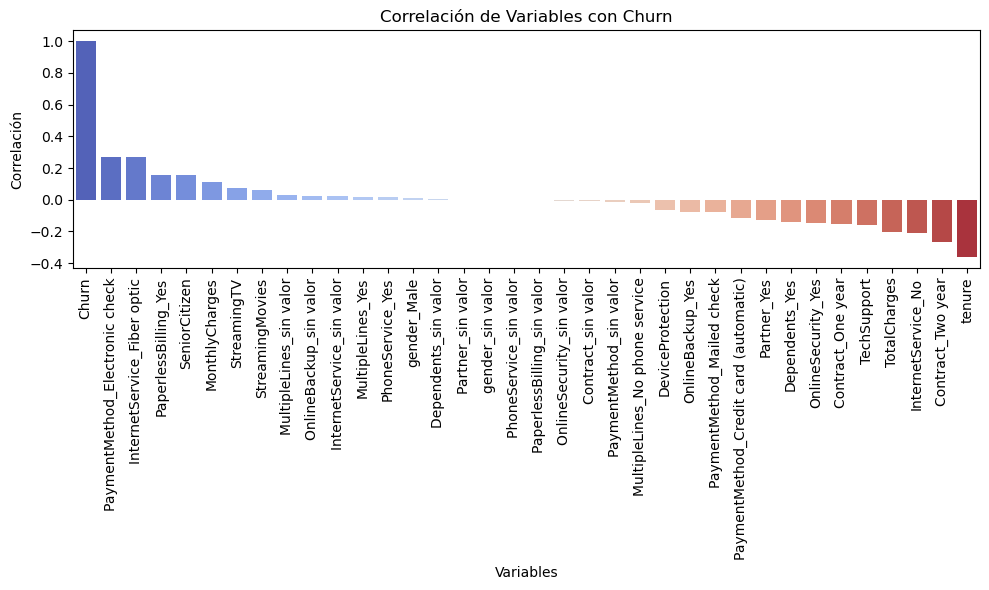

In [2271]:
# Visualizo las correlaciones con un gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_churn.index, y=correlation_with_churn.values, palette='coolwarm')
plt.xticks(rotation=90)
plt.title('Correlación de Variables con Churn')
plt.xlabel('Variables')
plt.ylabel('Correlación')
plt.tight_layout()
plt.show()

In [2273]:
#Elimino las variables cuya correlacion sea menor al 0,05

In [2275]:
threshold = 0.05 

In [2277]:
less_relevant_variables = correlation_with_churn[correlation_with_churn.abs() < threshold]

In [2279]:
print("\nVariables con menor relevancia:")
print(less_relevant_variables)


Variables con menor relevancia:
MultipleLines_sin valor           0.030121
OnlineBackup_sin valor            0.022006
InternetService_sin valor         0.021367
MultipleLines_Yes                 0.019324
PhoneService_Yes                  0.016072
gender_Male                       0.011912
Dependents_sin valor              0.005044
Partner_sin valor                 0.001336
gender_sin valor                 -0.001925
PhoneService_sin valor           -0.002323
PaperlessBilling_sin valor       -0.004757
OnlineSecurity_sin valor         -0.006908
Contract_sin valor               -0.010892
PaymentMethod_sin valor          -0.011118
MultipleLines_No phone service   -0.018247
Name: Churn, dtype: float64


In [2281]:
telco_reduced = telco_opcion2.drop(columns=less_relevant_variables.index)

In [2283]:
print(f'Nos quedamos con un data-set de {telco_reduced.shape[0]} filas x{telco_reduced.shape[1]} columnas')

Nos quedamos con un data-set de 5320 filas x21 columnas


In [2285]:
telco_reduced.head(3)

,SeniorCitizen,tenure,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MonthlyCharges,TotalCharges,Churn,OnlineBackup_Yes,OnlineSecurity_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,Partner_Yes,Dependents_Yes,PaperlessBilling_Yes
1,0.0,34.0,1,0,0,0,0.00,1889.50,0,0,1,0,0,1,0,0,1,0,0,0,0
2,0.0,2.0,0,0,0,0,53.85,108.15,1,0,1,0,0,1,0,0,0,0,0,0,1
5,0.0,8.0,1,0,1,1,99.65,820.50,1,0,0,0,1,0,1,0,0,0,0,0,0


#### Guardar el DataFrame procesado como un archivo CSV para levantarlo en Notebook "Modelo de entrenamiento"

In [2288]:
telco_reduced.to_csv('telco_processed2.csv', index=False)

In [2290]:
# Busco la ruta para levantarlos luego
import os


files_to_find = ['telco_processed1.csv', 'telco_processed2.csv']

for file_name in files_to_find:
    for root, dirs, files in os.walk('.'):
        if file_name in files:
            full_path = os.path.abspath(os.path.join(root, file_name))
            print(f"Archivo encontrado: {full_path}")

Archivo encontrado: C:\Users\joaqpach\Desktop\FA\Ciencia de datos\TP Final\telco_processed1.csv
Archivo encontrado: C:\Users\joaqpach\Desktop\FA\Ciencia de datos\TP Final\telco_processed2.csv
